# Sistemas Inteligentes: Aprendizaje Automático

_Guillermo Facundo Colunga_

**Datos entorno desarrollo:**  
**SO:** Windows 10.  
**Cores:** 16.  
**RAM:** 16 Gb.  
**Librerías empleadas:** `caret`, `ggplot2`, `gridExtra`, `reshape2` y `doMC`.

# Introducción

Esta práctica de aprendizaje automático se enmarca en explorar los distintos paradigmas de clasificación estudiados en la asignatura para seleccionar aquel que mejor prediga el tipo de actividad que realiza una persona según la información proporcionada por los sensores que lleva una persona.

Para ello se evaluarán los paradigmas de clasificación **árbol de decisión, vecinos más cercanos, redes neuronales y máquinas de vector soporte** a través del paquete `caret` de R. 

Finalmente se realizará la comparación de los resultados aportados por los diferentes paradigmas y se seleccionará aquel que mejor precisión tenga como _el mejor_.


# Configuración espacio de trabajo en R

Empezamos configurando R e importanto el paquete `caret`. De la misma forma cargamos las librerías necesarias que vamos a utilizar durante el desarrollo de la práctica y eliminamos los warnings de nuestro script para limpiar las salidas.

In [39]:
# Eliminamos los warnings del script ya que ensucian el script
options(warn=-1)

# Realizamos los imports necesarios
library(caret)

# Carga de datos en R

Una vez tenemos R configurado y con las librerías necesarias cargadas, importamos los datos sobre los que vamos a dearrollar nuestros modelos. Para ello descargamos en el directorio el siguiente banco de [datos](http://archive.ics.uci.edu/ml/datasets/Wearable+Computing%3A+Classification+of+Body+Postures+and+Movements+%28PUC-Rio%29) y lo importamos con el siguiente código.

In [40]:
load("har.RData")

Este conjunto de datos contiene 19 variables y 165.633 instancias, para que el análisis se pueda hacer en menos tiempo usaremos sólo 10.000 instancias que vendrán dadas por nuestro identificador universitario.

In [41]:
# Configuramos nuestro identificador universitario
uo <- 236856
n_instancias <- 10000

Una vez configurados el identificador universitario y el número de instancias filtramos los datos del banco y los asignamos a la variable filtered.

In [42]:
set.seed(uo) #Pon aquí los número de tu UO
filtered <- har[sample(nrow(har)-1,n_instancias),]

Además vamos a eliminar las 5 columnas que contienen información relativa a cada participante en el estudio para emplear sólo la información del movimiento

In [43]:
filtered$age<-NULL
filtered$user<-NULL
filtered$gender<-NULL
filtered$how_tall_in_meters<-NULL
filtered$weight<-NULL
filtered$body_mass_index<-NULL

Mostramos la cabecera de la tabla de datos resultante tras realizar el pre-procesado.

In [44]:
# Mostramos los datos con los que trabajaremos.
head(filtered)

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4,class
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>
99892,-11,98,-124,-1,92,-136,35,124,-76,-170,-72,56,standing
65004,-1,108,-99,10,90,-123,27,107,-95,-175,-91,59,standing
30560,4,72,-61,-21,10,-22,89,81,-140,-96,-118,84,sitting
17434,-26,35,-28,-240,-231,-347,38,108,-102,-153,-92,66,sitting
69154,-5,103,-85,6,74,-120,35,105,-84,-151,-98,49,standing
35365,1,66,-63,-20,6,-26,67,60,-102,-95,-120,69,sitting


En la tabla anterior se puede ver que tenemos las variables x1, y1, z1, ... x4, y4, z4. Cada conjunto (x, y, z) se corresponde con los datos de un acelerómetro ubicado en una extremidad de la persona. La última columna se corresponde con la actividad del registro.

# Esquema de evaluación

Conocemos que existen distintos tipos de validación, cada uno con sus ventajas y desventajas. Sin embargo, para nuestro problema realizaremnos una división 80%/20% para entrenamiento/test. Esto nos permitirá realizar una validación externa para ver como de bueno es realmente el modelo ocn datos que no ha visto durante el procesod e entrenamiento.

In [45]:
training_percentage <- .8

In [46]:
inTrain <- createDataPartition(
    # indicamos la clase
    y = filtered$class,
    
    # el porcentaje de instancias para entrenamiento
    p = training_percentage,
    
    # controla el formato de salida
    list = FALSE
)

# Definimos nuestras particiones de entrenamiento y validación.
training <- filtered[ inTrain,]
testing <- filtered[-inTrain,]

A continuación, como tenemos un gran número de instancias (10.000) emplearemos el sistema de validación cruzada con valor de k 10.

In [47]:
crossValidation <- trainControl(method = "cv", number = 10)

# Métrica de comparación de modelos

A contianuación se muestra el número de datos de cada clase así como el porcentaje de datos de cada clase contenidos en el banco de datos.

In [48]:
cat('Número de datos de cada clase: \n')
summary(filtered$class)
cat('\nPorcentaje de datos de cada clase: \n')
summary(filtered$class)/sum(summary(filtered$class))

Número de datos de cada clase: 


sitting sittingdown    standing  standingup     walking 
       3064         739        2819         737        2641


Porcentaje de datos de cada clase: 


sitting sittingdown    standing  standingup     walking 
     0.3064      0.0739      0.2819      0.0737      0.2641

De los datos anteriores podemos obtener que las clases están desbalanceadas ya que por ejemplo `standing` representa el 29% de los datos y `sittingdown` el 7%. Por tanto emplearemos la métrica kappa, que nos permite saber cómo de bueno es un clasificador en comparación con una predicción basada en la frecuencia de las clases. Además, dicha métrica tiene en cuenta también el valor del porcentaje de acierto.

# Generación de modelos

In [49]:
# Creamos una función para ver los resultados de la validación interna
internalValidation <- function(model){
  print(model)
  print(model$results[rownames(model$bestTune),1:4])
}

In [50]:
# Creamos una función para ver los resultados de la validación externa
externalValidation <- function(model, testingData = testing){
  print(confusionMatrix(predict(model,testingData),testingData$class))
}

## Árboles de decisión

De acuerdo con la teoría, un árbol de decisión es un mecanismo en el que dado un conjunto de datos se fabrican diagramas de construcciones lógicas, muy similares a los sistemas de predicción basados en reglas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva, para la resolución de un problema. Por lo tanto, y teniendo en cuenta nuestros datos, parece un modelo que nos dará unos buenos resultados, sin embargo, vamos a contrastar esta hipótesis.

Tanto en teroría como en prácticas vimos distintos modelos de árboles de decisión, a continuación implementaremos los modelos J48, rpart y rpart2 para comparar su precisión para el problema dado.

In [51]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con J48.
c4.5Fit <- train(
    class ~ .,
    data = training,
    method = "J48",
    trControl = crossValidation,
    tuneLength = 7,
    metric = "Kappa"
    # Empleamos C=0.04 y M=2 ya que son los valores que tras explorar
    # nos han dado mejor resultado y realizar siempre la exploración
    # de valores es demasiado lenta.
    # tuneGrid = data.frame(C=0.04, M=2)
)

In [52]:
# Resultados validación interna
internalValidation(c4.5Fit)

C4.5-like Trees 

8003 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7204, 7204, 7201, 7201, 7203, 7203, ... 
Resampling results across tuning parameters:

  C           M  Accuracy   Kappa    
  0.01000000  1  0.9378992  0.9166412
  0.01000000  2  0.9366507  0.9149982
  0.01000000  3  0.9319052  0.9086175
  0.01000000  4  0.9320289  0.9087678
  0.01000000  5  0.9329027  0.9098962
  0.01000000  6  0.9305260  0.9066841
  0.01000000  7  0.9270309  0.9020117
  0.09166667  1  0.9407716  0.9205463
  0.09166667  2  0.9397716  0.9192294
  0.09166667  3  0.9349010  0.9126812
  0.09166667  4  0.9346508  0.9123167
  0.09166667  5  0.9353999  0.9133286
  0.09166667  6  0.9331494  0.9102578
  0.09166667  7  0.9294058  0.9052730
  0.17333333  1  0.9410218  0.9208859
  0.17333333  2  0.9401464  0.9197466
  0.17333333  3  0.9350275  0.9128604
  0.17333333  4  0.9352

El valor máximo de C es 0.5 y podemos observar que el mejor resultado se obtiene con M = 2, a partir de ahí a mayor M peores resultados. Por tanto los valores C = 0.09166667 y M = 2son los mejores posebles.

In [53]:
# Resultados validación externa
externalValidation(c4.5Fit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         604           2        0          4       1
  sittingdown       4         126        4          9       4
  standing          0           6      541          4       9
  standingup        4           5        2        126       9
  walking           0           8       16          4     505

Overall Statistics
                                          
               Accuracy : 0.9524          
                 95% CI : (0.9422, 0.9613)
    No Information Rate : 0.3065          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9362          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9869            0.85714          0.9609


**Resultados:**

Validación interna (Acc. = 0.9463912 / Kappa = 0.9280605)

Validación externa (Acc. = 0.9439 / Kappa = 0.9248)

## CART

Vamos a probar ahora con un árbol de decisión que emplea el algoritmo CART (rpart y rpart2).

### Rpart

Primero probaremos con la versión rpart, que utiliza el parámetro cp (solo se introducirá un nodo en el árbol cuando permita que se reduzca el error en al menos el valor de cp).

In [54]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con rpart.
rpartFit <- train(
    class ~ .,
    data = training,
    method = "rpart",
    trControl = crossValidation,
    tuneLength = 10,
    metric = "Kappa"
)

In [55]:
# Resultados validación interna
internalValidation(rpartFit)

CART 

8003 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7204, 7204, 7201, 7201, 7203, 7203, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa    
  0.007025761  0.8479392  0.7939362
  0.007926500  0.8429406  0.7868335
  0.013511079  0.8391945  0.7812161
  0.017294181  0.8214442  0.7565933
  0.018194920  0.8160763  0.7488835
  0.029904522  0.7937055  0.7173787
  0.049360476  0.7378329  0.6359249
  0.072959827  0.6953743  0.5742753
  0.179967573  0.6054883  0.4458561
  0.346604215  0.4482017  0.2142049

Kappa was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.007025761.
           cp  Accuracy     Kappa AccuracySD
1 0.007025761 0.8479392 0.7939362 0.01646071


A medida que aumenta el cp se puede ver que el resultado empeora, el mejor es el más bajo 0.00826892.

In [56]:
# Resultados validación externa
externalValidation(rpartFit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         596           4        0         21       1
  sittingdown       6          81       13          9       8
  standing          0          14      478         27      32
  standingup        9          21        0         60       8
  walking           1          27       72         30     479

Overall Statistics
                                          
               Accuracy : 0.8483          
                 95% CI : (0.8318, 0.8637)
    No Information Rate : 0.3065          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7945          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9739            0.55102          0.8490


**Resultados:**

Validación interna (Acc. = 0.8531658 / Kappa = 0.8010712)

Validación externa (Acc. = 0.8468 / Kappa = 0.7909)

Se puede observar que tanto en el caso de la validación interna como externa los datos obtenidos con el modelo C4.5 son mejores.

### Rpart2

Ahora probamos con la versión rpart2 que emplea el parámetro maxdepth para controlar la profundidad del árbol. Vamos a modeificar el tunelenght hasta 21 para poder cubrir todos los posibles valores.

In [57]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con rpart2.
rpart2Fit <- train(
    class ~ .,
    data = training,
    method = "rpart2",
    trControl = crossValidation,
    tuneLength = 21,
    metric = "Kappa"
)

In [58]:
# Resultados validación interna
internalValidation(rpart2Fit)

CART 

8003 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7204, 7204, 7201, 7201, 7203, 7203, ... 
Resampling results across tuning parameters:

  maxdepth  Accuracy   Kappa    
   1        0.5464205  0.3620752
   2        0.6712545  0.5391191
   3        0.7218504  0.6122917
   5        0.7887091  0.7104425
   6        0.8094537  0.7391536
   7        0.8184493  0.7522593
   8        0.8319433  0.7711158
   9        0.8415676  0.7844391
  10        0.8415676  0.7844391
  11        0.8415676  0.7844391
  12        0.8415676  0.7844391
  15        0.8415676  0.7844391
  17        0.8415676  0.7844391
  18        0.8415676  0.7844391
  19        0.8415676  0.7844391
  20        0.8415676  0.7844391
  23        0.8415676  0.7844391
  24        0.8415676  0.7844391
  26        0.8415676  0.7844391
  28        0.8415676  0.7844391
  29        0.8415676  0.

Podemos ver que a apartir de una profundidad de 11 el valor de la precisión y de kappa se mantiene constante. Por lo tanto se seleccionará la profundidad de 11 como óptima.

In [59]:
# Resultados validación externa
externalValidation(rpart2Fit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         602          28        9         21       3
  sittingdown       0          57        4          9       6
  standing          0          14      478         27      32
  standingup        9          21        0         60       8
  walking           1          27       72         30     479

Overall Statistics
                                          
               Accuracy : 0.8393          
                 95% CI : (0.8224, 0.8551)
    No Information Rate : 0.3065          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7808          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9837            0.38776          0.8490


**Resultados:**

Validación interna (Acc. = 0.8457903 / Kappa = 0.7901717)

Validación externa (Acc. = 0.8468 / Kappa = 0.7909)

Se puede observar que tanto en el caso de la validación interna como externa los datos obtenidos con el modelo C4.5 son mejores. Sin embargo pese a que en la validación interna el árbol rpar2 sea peor que el árbol rpart en la validación externa ambos modelos tienen un rendimiento idéntico.

### Conclusión árboles de decisión

Con los resultados obtenidos podemos decir que el mejor árbol es el C4.5 ya que con nuestro esquema de validación es el que mejor tasa de acierto tiene. Por tanto será el modelo seleccionado de árboles de decisión.

## Vecinos más cercanos (kNN)

Otro de los paradigmas de clasificación vistos durante la asginatura es el de vecinos más cercanos o knn por sus siglas en inglés. Este paradigma no tiene un modelo, lo que hace es comparar el ejemplo con los datos a predecir y a través de distancias a k vecinos más cercanos precedir la clase.

In [60]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo con knn.
knnFit <- train(
  class ~ .,
  data = training,
  method = "knn",
  trControl = crossValidation,
  tuneLength = 10 # k. Número de vecinos a comprobar.
)

In [61]:
# Resultados validación interna
internalValidation(knnFit)

k-Nearest Neighbors 

8003 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7204, 7204, 7201, 7201, 7203, 7203, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.9707599  0.9607891
   7  0.9657630  0.9540776
   9  0.9636380  0.9512303
  11  0.9598884  0.9461700
  13  0.9556398  0.9404557
  15  0.9512674  0.9345635
  17  0.9468929  0.9286500
  19  0.9426435  0.9229117
  21  0.9396463  0.9188516
  23  0.9355228  0.9132695

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 5.
  k  Accuracy     Kappa  AccuracySD
1 5 0.9707599 0.9607891 0.005475589


In [62]:
# Resultados validación externa
externalValidation(knnFit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         606           0        0          1       0
  sittingdown       1         138        1          6       4
  standing          0           4      560          4      10
  standingup        5           3        2        132       3
  walking           0           2        0          4     511

Overall Statistics
                                          
               Accuracy : 0.975           
                 95% CI : (0.9671, 0.9814)
    No Information Rate : 0.3065          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9664          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9902            0.93878          0.9947


**Resultados:**

Validación interna (Acc. = 0.9696309 / Kappa = 0.9592485)

Validación externa (Acc. = 0.9725 / Kappa = 0.9631)

En este modelo puede verse que los resultados con la validación externa superan, muy ligeramente, a los resultados obtenidos durante el aprendizaje.

## Redes neuronales

Este es un método de clasificación no paramétrico, que estima el valor de la función de densidad de probabilidad o directamente la probabilidad a posteriori de que un elemento x pertenezca a la clase C a partir de la información proporcionada por el conjunto de prototipos. En el proceso de aprendizaje no se hace ninguna suposición acerca de la distribución de las variables predictoras.

In [63]:
plotNNErrorEvolution <- function(nnModel){
  ggplot() + geom_line(aes(x=1:length(nnModel$finalModel$IterativeFitError), 
                           y=nnModel$finalModel$IterativeFitError)) +
  xlab("Iteraciones") + ylab("Error") 
}

### 1 capa oculta

In [64]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit <- train(
    class ~ .,
    data = training,
    method = "mlp",
    trControl = crossValidation,
    metric = "Kappa",
    preProcess=c("center","scale"),
    tuneGrid = data.frame(size=seq(10,110,20))
)

nneurons1L <- nn1LFit$results[rownames(nn1LFit$bestTune),1]

In [65]:
# Resultados validación interna
internalValidation(nn1LFit)

Multi-Layer Perceptron 

8003 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

Pre-processing: centered (12), scaled (12) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7204, 7204, 7201, 7201, 7203, 7203, ... 
Resampling results across tuning parameters:

  size  Accuracy   Kappa    
   10   0.9336492  0.9108437
   30   0.9563894  0.9415687
   50   0.9597649  0.9460436
   70   0.9605110  0.9470474
   90   0.9642643  0.9520938
  110   0.9625124  0.9497755

Kappa was used to select the optimal model using the largest value.
The final value used for the model was size = 90.
  size  Accuracy     Kappa  AccuracySD
5   90 0.9642643 0.9520938 0.008204571


En la validación interna los resultados ya son aceptables en un primer lugar, obtenemos una kappa de 0.9520938 y un acc. de 0.9642643 para una capa oculta de 90 neuronas. Así mismo vemos que el valor optimo de neuronas se encuentra en algún punto entre 70 y 110, vamos a intentar acercarnos más al valor optimo.

In [66]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit2 <- train(
    class ~ .,
    data = training,
    method = "mlp",
    trControl = crossValidation,
    metric = "Kappa",
    preProcess=c("center","scale"),
    tuneGrid = data.frame(size=seq(nneurons1L-10,nneurons1L+10,2))
)

In [67]:
# Resultados validación interna
internalValidation(nn1LFit2)

Multi-Layer Perceptron 

8003 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

Pre-processing: centered (12), scaled (12) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7204, 7204, 7201, 7201, 7203, 7203, ... 
Resampling results across tuning parameters:

  size  Accuracy   Kappa    
   80   0.9641395  0.9519527
   82   0.9645148  0.9524162
   84   0.9646363  0.9526111
   86   0.9637577  0.9514665
   88   0.9621377  0.9492845
   90   0.9657587  0.9540979
   92   0.9635138  0.9511372
   94   0.9666384  0.9552854
   96   0.9646353  0.9526259
   98   0.9667612  0.9554579
  100   0.9651390  0.9533004

Kappa was used to select the optimal model using the largest value.
The final value used for the model was size = 98.
   size  Accuracy     Kappa  AccuracySD
10   98 0.9667612 0.9554579 0.007132163


Con la exploración anterior encontramos que con 98 neuronas en la capa oculta el modelo consigue una precisión de 0.9667612 y un kappa de 0.9554579. A demás vemos que a partir de 98 el desempeño de la red decae de nuevo por lo que este será el valor "óptimo". Sin embargo vamos a tratar de ver como ha sido el aprendizaje de la red, primero con la matriz de confusión y luego con la gráfica d eentrenamiento.

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         609           0        0          1       1
  sittingdown       1         136        0          3       2
  standing          0           3      541          4       4
  standingup        2           5       15        137       5
  walking           0           3        7          2     516

Overall Statistics
                                          
               Accuracy : 0.971           
                 95% CI : (0.9626, 0.9779)
    No Information Rate : 0.3065          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9611          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9951            0.92517          0.9609


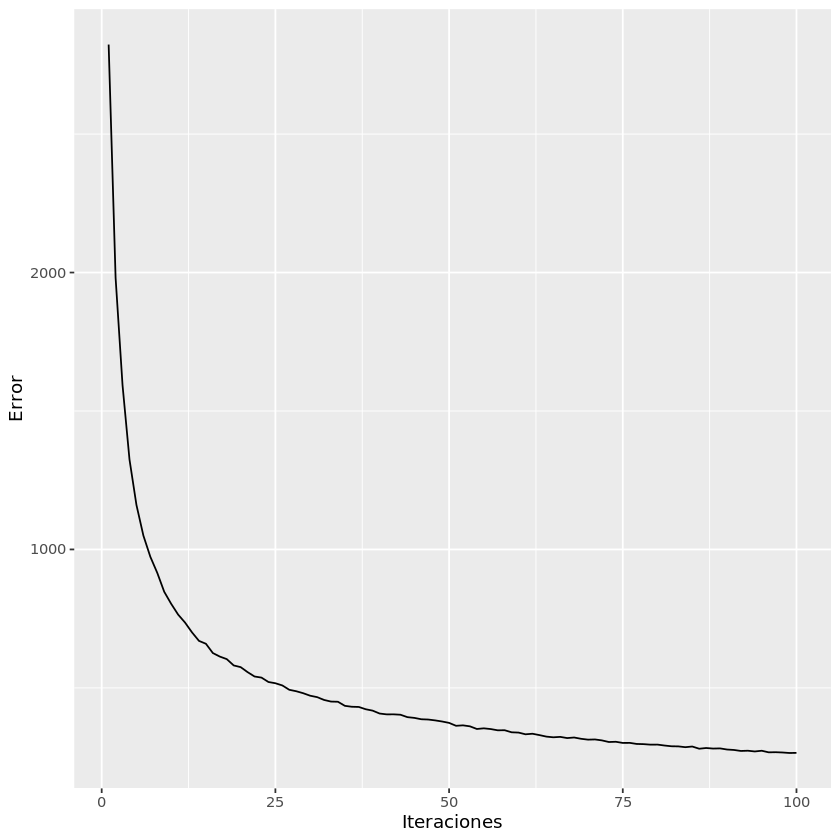

In [68]:
externalValidation(nn1LFit2)

# Dibujamos la evolución del error a lo largo de las iteraciones de la red
plotNNErrorEvolution(nn1LFit2)

Como vemos, la curva de entrenamiento es más o menos aceptable ya que no encontramos grandes picos en el error. Sin embargo si observamos que en la iteración número 100 que es donde detenemos nuestro entrenamiento el error aún es descendente. Esto significa que probablemente si continuamos entrenando durante más de 100 iteraciones consigamos unos resultados de desempeño de la red mcho mayores.

In [69]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit2_maxit300 <- train(
    class ~ .,
    data = training,
    method = "mlp",
    trControl = crossValidation,
    metric = "Kappa",
    preProcess=c("center","scale"),
    tuneGrid = data.frame(size=98),
    maxit=300
)

In [70]:
# Resultados validación interna
internalValidation(nn1LFit2_maxit300)

Multi-Layer Perceptron 

8003 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

Pre-processing: centered (12), scaled (12) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7204, 7204, 7201, 7201, 7203, 7203, ... 
Resampling results:

  Accuracy  Kappa    
  0.968386  0.9576379

Tuning parameter 'size' was held constant at a value of 98
  size Accuracy     Kappa AccuracySD
1   98 0.968386 0.9576379 0.01185008


Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         609           1        0          1       1
  sittingdown       0         136        0          7       3
  standing          0           2      558          5       3
  standingup        3           3        2        134       2
  walking           0           5        3          0     519

Overall Statistics
                                          
               Accuracy : 0.9795          
                 95% CI : (0.9722, 0.9852)
    No Information Rate : 0.3065          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9725          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9951            0.92517          0.9911


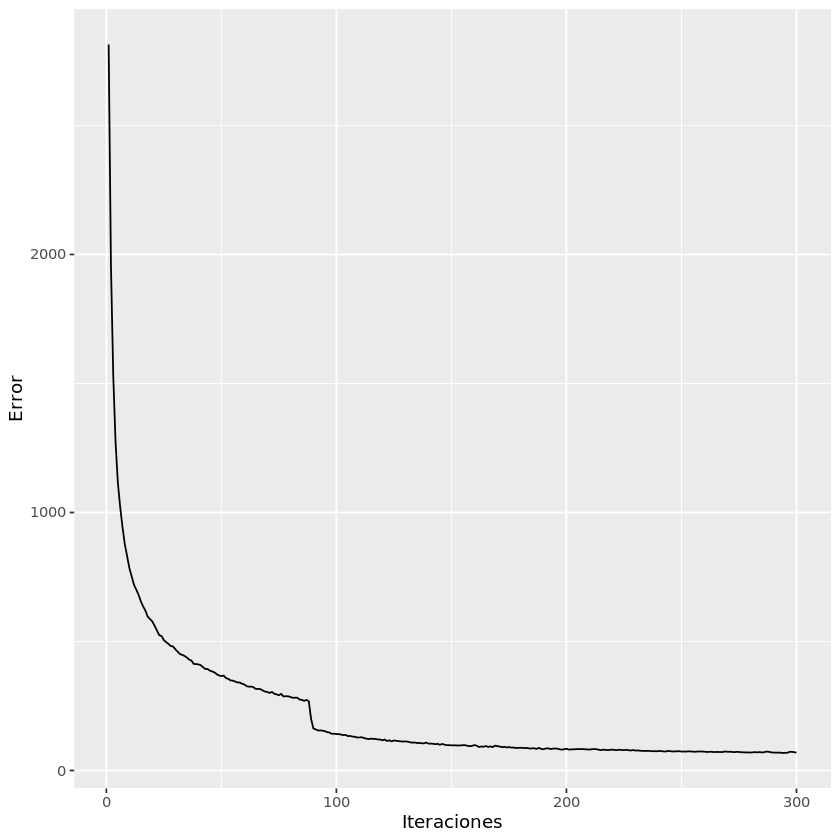

In [71]:
externalValidation(nn1LFit2_maxit300)

# Dibujamos la evolución del error a lo largo de las iteraciones de la red
plotNNErrorEvolution(nn1LFit2_maxit300)

En la gráfica anterior podemos ver que el error se disminuye a partir de la iteración 100 sin embargo también nos aparece un pico decreciente en el error que antes no estaba, para intentar que el proceso de aprendizaje sea más lineal vamos a probar a jugar con el parámetro de ratio de aprendizaje.

In [72]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

# Realizamos el entrenamiento de nuestro modelo
nn1LFit2_maxit300_lr02 <- train(
    class ~ .,
    data = training,
    method = "mlp",
    trControl = crossValidation,
    metric = "Kappa",
    preProcess=c("center","scale"),
    tuneGrid = data.frame(size=98),
    maxit=300,
    leanFuncParam = c(0.02,0)
)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         609           1        0          1       1
  sittingdown       0         136        0          7       3
  standing          0           2      558          5       3
  standingup        3           3        2        134       2
  walking           0           5        3          0     519

Overall Statistics
                                          
               Accuracy : 0.9795          
                 95% CI : (0.9722, 0.9852)
    No Information Rate : 0.3065          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9725          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9951            0.92517          0.9911


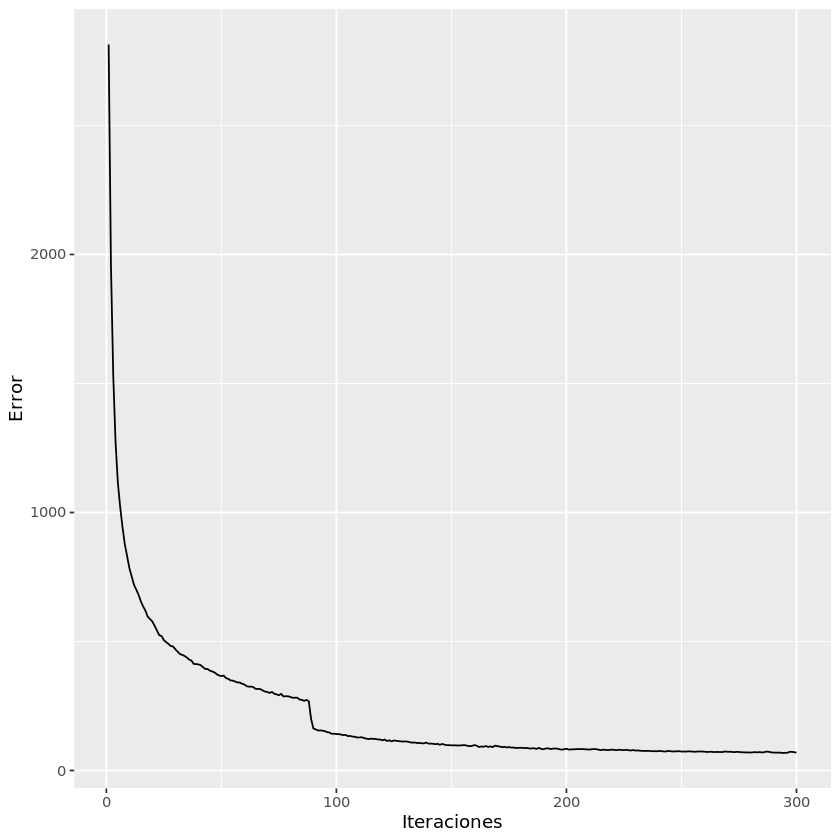

In [73]:
externalValidation(nn1LFit2_maxit300_lr02)

# Dibujamos la evolución del error a lo largo de las iteraciones de la red
plotNNErrorEvolution(nn1LFit2_maxit300_lr02)

Para el modelo anterior encontramos que la precisión más elevada se da cuando empleamos 60 neuronas en la capa oculta, con un 98.8% sobre los datos de entrenamiento y un 98.99% sobre los datos de validación.

Vamos a probar con redes más profundas, pero limitando la complejidad (número de parámetros) a un nivel similar a la red anterior.

El test binomial nos indica que durante el entrenamiento no se puede tomar la diferencia como significativa. Los dos modelos ajustan los datos de entrenamiento de manera similar pero el modelo de una única capa oculta es capaz de generalizar mejor.

## Máquinas vector soporte

Estos métodos están propiamente relacionados con problemas de clasificación y regresión. Dado un conjunto de ejemplos de entrenamiento (de muestras) podemos etiquetar las clases y entrenar una SVM para construir un modelo que prediga la clase de una nueva muestra. Intuitivamente, una SVM es un modelo que representa a los puntos de muestra en el espacio, separando las clases a 2 espacios lo más amplios posibles mediante un hiperplano de separación definido como el vector entre los 2 puntos, de las 2 clases, más cercanos al que se llama vector soporte. Cuando las nuevas muestras se ponen en correspondencia con dicho modelo, en función de los espacios a los que pertenezcan, pueden ser clasificadas a una o la otra clase.

De la misma forma que con los árboles de decisión para las máquinas de vector soporte encontramos diferentes tipos, Lineares, Polinomial y Radial

In [74]:
# Plantamos la semilla para obtener un valor constante tras cada ejecución.
set.seed(uo)

svmLinealFit <- train(
    class ~ .,
    data = training,
    method = "svmLinear",
    trControl = crossValidation,
    tuneGrid = data.frame(C=c(0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5)),
    metric = "kappa"
)

In [75]:
# Resultados validación interna
internalValidation(svmLinealFit)

Support Vector Machines with Linear Kernel 

8003 samples
  12 predictor
   5 classes: 'sitting', 'sittingdown', 'standing', 'standingup', 'walking' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7204, 7204, 7201, 7201, 7203, 7203, ... 
Resampling results across tuning parameters:

  C      Accuracy   Kappa    
  0.001  0.7163551  0.6065754
  0.005  0.7885844  0.7111782
  0.010  0.8045737  0.7342568
  0.050  0.8256870  0.7644230
  0.100  0.8304357  0.7712231
  0.500  0.8343109  0.7766802
  1.000  0.8351856  0.7778427
  5.000  0.8363062  0.7794994

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 5.
  C  Accuracy     Kappa AccuracySD
8 5 0.8363062 0.7794994 0.01598872


In [76]:
# Resultados validación externa
externalValidation(svmLinealFit)

Confusion Matrix and Statistics

             Reference
Prediction    sitting sittingdown standing standingup walking
  sitting         606           4        0          5       0
  sittingdown       1         100        4         14      24
  standing          0          29      534         23     133
  standingup        5          10        1         92       5
  walking           0           4       24         13     366

Overall Statistics
                                          
               Accuracy : 0.8503          
                 95% CI : (0.8339, 0.8657)
    No Information Rate : 0.3065          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7979          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: sitting Class: sittingdown Class: standing
Sensitivity                  0.9902            0.68027          0.9485
